### Integration of SVM and MVO 
The idea is to integrate support vector machines and mean variance optimization by considering an investor who instead of simply optimizing the mean variance criterion, uses a linear boundary to decide what assets are to be included in the long-only portfolio. The investor will select the bundary to be of maximum margin while minimizing the portfolio variance. 

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_{i} z_i \leq N \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$

In [89]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math
import time

from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *


%matplotlib inline

## Import Forecasts

forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

In [90]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [91]:
#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N] + np.min(np.linalg.eigvals(cov_[:N,:N]))*np.eye(N)
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest

#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Vol"] # Y matrix in formulation as per the paper
Y_normalized =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_normalized = Y_normalized.iloc[:,:]
#Y_normalized = Y_normalized[['ROC1', 'INV1', 'PRO1'	, 'GRW1', 'LEV1', 'LIQ1']]
#Y_normalized['momentum'] = mean
Y_normalized = Y_normalized[['LEV1', 'GRW1']]

ret_constr = -1 #no return constraint
soft_margin = 5000 #large preference for separation feasibility
cardinality_total = True #consider as % of total assets if true else consider as % of MVO cardinality
ratio = 0.8 #% of assets
epsilon = 1e-3 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

Text(0.5, 1.0, 'The space of attributes $\\mathcal{Y}$')

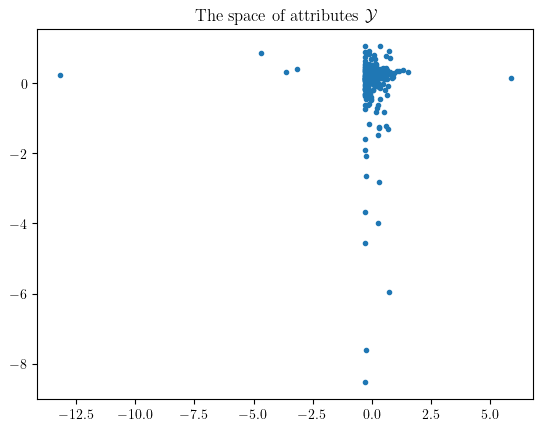

In [92]:
plt.plot(Y_normalized.iloc[:,0], Y_normalized.iloc[:, 1],".")
plt.title("The space of attributes $\mathcal{Y}$")

In [93]:
print("Number of Balance Sheet Factors: ", len(wrds_svm.loc[:,'srcq':'prccq'].columns))
print("Number of periods for optimization: ", len(rets))

Number of Balance Sheet Factors:  38
Number of periods for optimization:  243


### Simple Min Variance Portfolio

In [94]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, asset_lim= None,
             svm_choice = (False, False), print_var_frntr= False, cardinality = False) #define an instance of the class
MVO.set_model() #set up the model
MVO.model.params.MIPGAP = 0.05
MVO.optimize() #find optimal solution

AssetLim = math.floor((MVO.x.x > 10**(-6)).sum()*ratio)
if cardinality_total:
    AssetLim = ratio*math.floor(N)
#
# MVO.asset_lim = AssetLim
# MVO.cardinality = True
# MVO.set_model() #set up the model
# MVO.model.params.MIPGAP = 0.05
# MVO.optimize() #find optimal solution

CCPO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, asset_lim= AssetLim,
             svm_choice = (False, False), print_var_frntr= False, cardinality = True) #define an instance of the class
CCPO.set_model() #set up the model
CCPO.model.params.MIPGAP = 0.05
CCPO.optimize() #find optimal solution


print(AssetLim)

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 572 columns and 572 nonzeros
Model fingerprint: 0x210a655e
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 286 columns
Presolve time: 0.02s
Presolved: 2 rows, 286 columns, 572 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 285
 AA' NZ     : 4.104e+04
 Factor NZ  : 4.133e+04 (roughly 1 MB of memory)
 Factor Ops : 7.921e+06 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.4231161

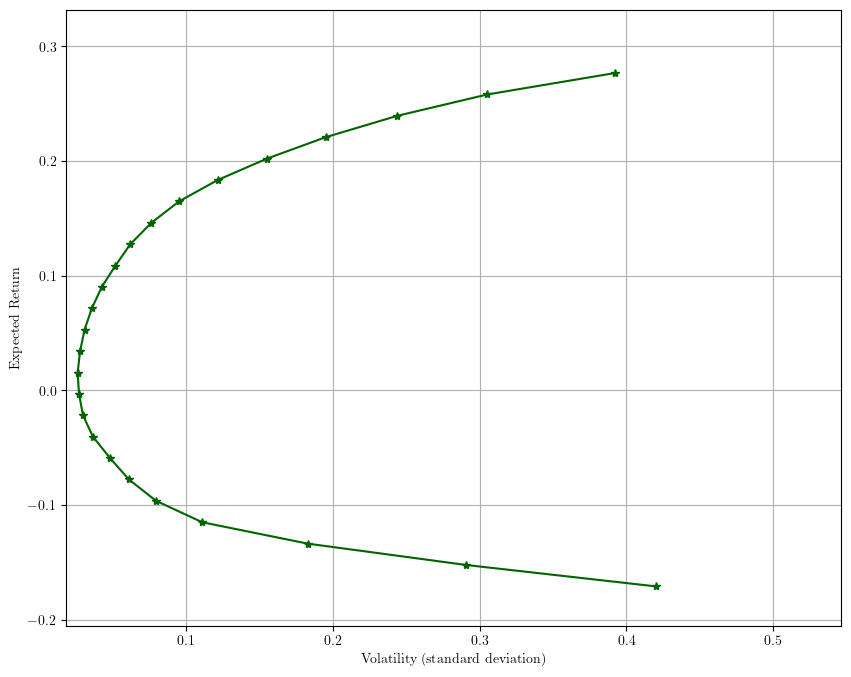

In [95]:
CCPO.model.setParam('OutputFlag', 0)
CCPO_frontier, ws, xis = CCPO.get_frontier(); #ws and xi are not important here

### Mean Variance and SVM Joint Formulation

In [96]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_normalized, AssetLim,
                 svm_choice = (True, False), print_var_frntr = False , indicator = False,
                 non_neg = non_negativity_setting, epsilon = epsilon)
SVM_MVO.set_model()
SVM_MVO.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 862 rows, 861 columns and 4004 nonzeros
Model fingerprint: 0x75440cd7
Model has 41043 quadratic objective terms
Variable types: 575 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Found heuristic solution: objective 0.0904264
Presolve removed 112 rows and 396 columns
Presolve time: 0.02s
Presolved: 750 rows, 465 columns, 2882 nonzeros
Presolved model has 41043 quadratic objective terms
Variable types: 289 continuous, 176 integer (176 binary)

Root relaxation: objective 6.870493e-04, 459 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd

12.042036056518555

In [97]:
SVM_MVO.w.x

array([0.03027239, 0.05956292])

In [98]:
SVM_MVO.b.x

array([0.00620327])

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 862 rows, 861 columns and 4004 nonzeros
Model fingerprint: 0x17599957
Model has 41043 quadratic objective terms
Variable types: 575 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]

MIP start from previous solve produced solution with objective 0.1787 (0.06s)
Loaded MIP start from previous solve with objective 0.1787

Presolve removed 111 rows and 396 columns
Presolve time: 0.02s
Presolved: 751 rows, 465 columns, 3168 nonzeros
Presolved model has 41043 quadratic objective terms
Variable types: 289 continuous, 176 integer (176 binary)

Root relaxation: objective 1.764675e-01, 423 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |

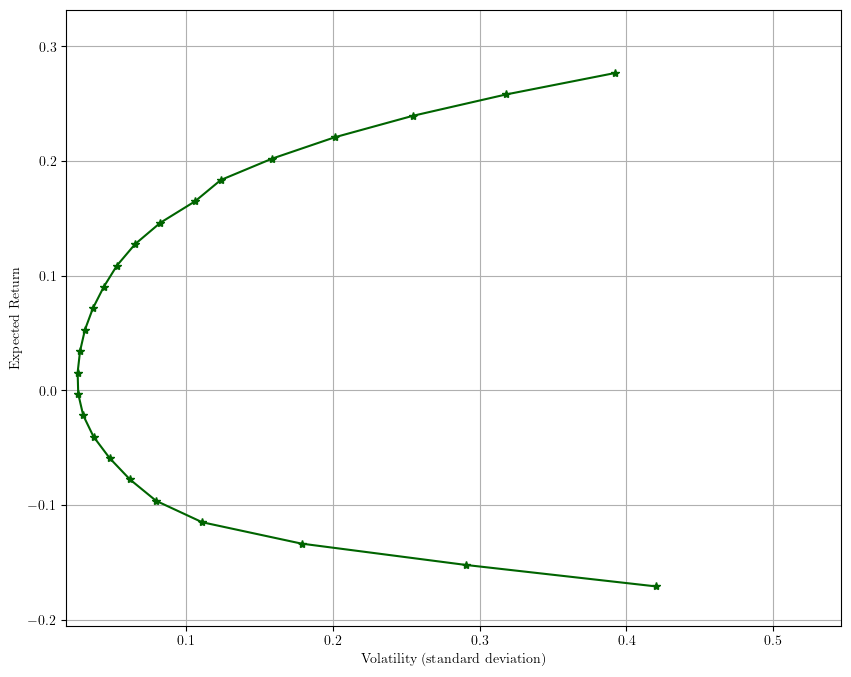

(array([[ 0.42008034,  0.29099181,  0.1787785 ,  0.11114712,  0.07979614,
          0.06197079,  0.04811297,  0.03717998,  0.03014062,  0.02676651,
          0.0263564 ,  0.02800489,  0.03133965,  0.03673052,  0.04410603,
          0.05310868,  0.06542886,  0.08263961,  0.10621782,  0.12381234,
          0.15875763,  0.20151153,  0.25450104,  0.31806569,  0.3920922 ],
        [-0.17088412, -0.15222962, -0.13357511, -0.11492061, -0.09626611,
         -0.07761161, -0.05895711, -0.04030261, -0.0216481 , -0.0029936 ,
          0.0156609 ,  0.0343154 ,  0.0529699 ,  0.07162441,  0.09027891,
          0.10893341,  0.12758791,  0.14624241,  0.16489692,  0.18355142,
          0.20220592,  0.22086042,  0.23951492,  0.25816943,  0.27682393]]),
 array([[ 0.00000000e+00,  0.00000000e+00, -1.00000000e-03],
        [-6.96569441e-04,  7.99638922e-08, -1.19354653e-03],
        [ 0.00000000e+00,  0.00000000e+00, -1.00000000e-03],
        [-6.34385904e-04,  2.33581443e-04, -1.09094859e-03],
        [-2.

In [99]:
SVM_MVO.get_frontier()

### There must be a model that is guaranteed to be feasible. Slack variables for the big M constraints will be introduced and penalized. These slack variables $\xi$ represent the degree of non-separability present among the assets

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 + \sum_{i=1}^N g(\xi_i)&\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_i z_i \leq N \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon + \xi_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon - \xi_i \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N  \quad \xi \geq 0& \\
\end{align} 
$$

This model is always feasible. A common setting for g is $C \xi/N$ where $C$ is a hyperparameter. 

In [100]:
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_normalized, AssetLim,\
                      svm_choice = (True, True), print_var_frntr = True, indicator = False,
                      non_neg = non_negativity_setting, epsilon = epsilon)
SVM_MVO_Slck.set_model()
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 862 rows, 1147 columns and 4576 nonzeros
Model fingerprint: 0x8b7f8ca5
Model has 41043 quadratic objective terms
Variable types: 861 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [2e+01, 2e+01]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Found heuristic solution: objective 1.000000e+13
Presolve removed 2 rows and 286 columns
Presolve time: 0.01s
Presolved: 860 rows, 861 columns, 4004 nonzeros
Presolved model has 41043 quadratic objective terms
Variable types: 575 continuous, 286 integer (286 binary)

Root relaxation: objective 6.870652e-04, 669 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

14.213213682174683

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 862 rows, 1147 columns and 4576 nonzeros
Model fingerprint: 0x06d8a4d4
Model has 41043 quadratic objective terms
Variable types: 861 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [2e+01, 2e+01]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]

MIP start from previous solve produced solution with objective 0.1787 (0.06s)
Loaded MIP start from previous solve with objective 0.1787

Presolve removed 1 rows and 286 columns
Presolve time: 0.02s
Presolved: 861 rows, 861 columns, 4290 nonzeros
Presolved model has 41043 quadratic objective terms
Variable types: 575 continuous, 286 integer (286 binary)

Root relaxation: objective 1.764675e-01, 649 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    | 

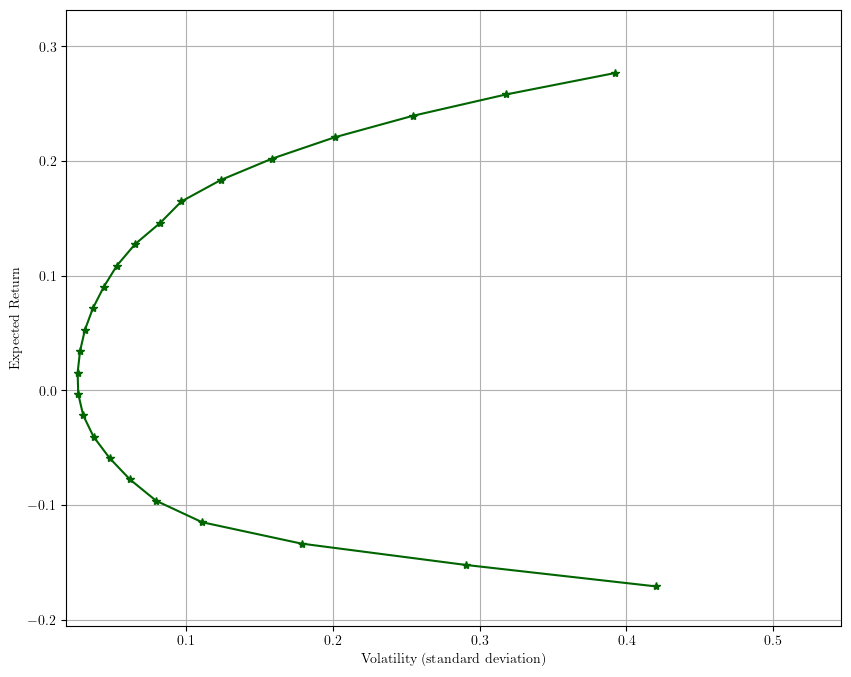

In [101]:
#SVM_MVO_Slck.model.setParam('OutputFlag', 0)
SVM_Slck_EF, ws, xis = SVM_MVO_Slck.get_frontier()

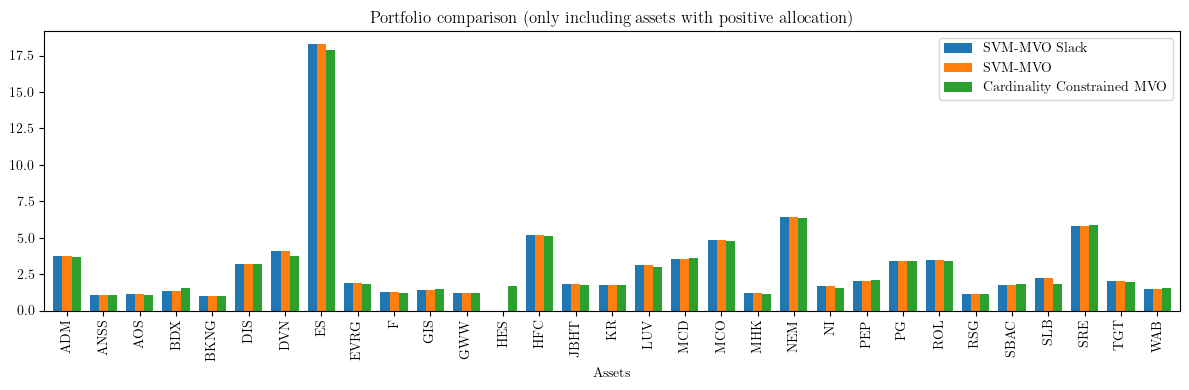

In [102]:
#portfolio comparison
out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO.get_results(), CCPO.get_results()], axis = 0)
(100*out[out.columns[(out > 0.01).any(axis = 0)]]).transpose()[:-2].plot.bar(title = 'Portfolio comparison (only including assets with positive allocation)',\
                                                                           xlabel = 'Assets', \
                                                                           ylabel = '% of Portfolio',\
                                                                           figsize = (12,4), width = 0.75);
plt.tight_layout()
plt.legend(['SVM-MVO Slack','SVM-MVO', 'Cardinality Constrained MVO'])   #override
plt.savefig(pth+"Images/p1.svg", dpi = dpi_setting)

For the portfolios up to the return point of 0.3, the solver finds linearly separable portfolios. After that point the solver defaults to including all the assets in the universe at the expense of increasing the cost of violating the linearly separable condition. 

The bias term acts as a radius that determines how far separating hyperplanes can be from the origin. If the bias was free to be any value then, it would be set to ensure z = 1 for all assets, which would imply w = 0, no constraint violations xi = 0 (since all assets are covered), and would therefore reduce the problem to the mean variance problem. 

The bias could be set to cover a percentile of assets feature vectors Y ?

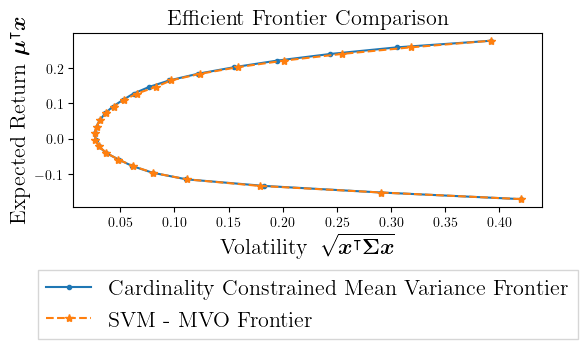

In [111]:
#Plot efficient frontiers for the SVM MVO an Vanilla MVO

plt.figure(figsize = (6,4))
plt.plot(CCPO_frontier[0], CCPO_frontier[1], ".-", label = "Cardinality Constrained Mean Variance Frontier");
plt.plot(SVM_Slck_EF[0], SVM_Slck_EF[1], "*--", label = "SVM - MVO Frontier");

plt.ylabel(r"Expected Return $\boldsymbol{\mu}^{\intercal} \boldsymbol{x}$", fontsize = 16)
plt.xlabel(r"Volatility\: $\sqrt{ \boldsymbol{x}^{\intercal}\boldsymbol{\Sigma} \boldsymbol{x} }$", fontsize = 16)

#plt.legend(loc = 'center right', fontsize = 16)
plt.legend(loc='upper center',
             bbox_to_anchor=(0.5, -0.3),
                 fancybox=False,
                 shadow=False, ncol=1,
                 fontsize = 16)
plt.title("Efficient Frontier Comparison", fontsize = 16)
plt.tight_layout()                                                                           
plt.savefig(pth+"Images/p2.svg", dpi = dpi_setting)

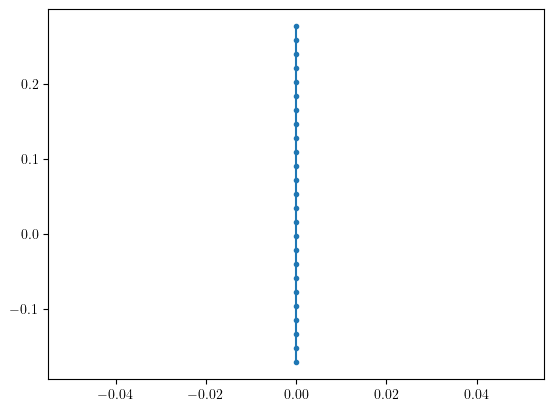

In [104]:
plt.plot(xis.sum(axis= 1), SVM_Slck_EF[1], ".-", label = "Slacks for each target");

In [105]:
supports  = pd.DataFrame(ws)
supports['ret'] = SVM_Slck_EF[1,:]
supports.drop([0, len(supports)-1],inplace = True)
big_m = 15
supports_uniq = supports.groupby([np.ceil(supports[0] * big_m) /big_m,  \
                  np.ceil(supports[1] * big_m) / big_m, \
                  np.ceil(supports[2] * big_m) / big_m]).first()
supports_uniq['last_ret'] = supports.groupby([np.ceil(supports[0] * big_m) /big_m,  \
                  np.ceil(supports[1] * big_m) / big_m, \
                  np.ceil(supports[2] * big_m) / big_m]).last()['ret']
supports_uniq['desc'] = "Return Target : " +  np.round(supports_uniq['ret'], decimals = 2).astype(str) \
                      +  " to " + np.round(supports_uniq['last_ret'], decimals = 2).astype(str) 

for idx in supports_uniq.index:
  if supports_uniq.loc[idx,'last_ret'] == supports_uniq.loc[idx,'ret']:
    supports_uniq.loc[idx, 'desc'] = "Return Target : " + \
                                      np.round(supports_uniq.loc[idx,'ret'], decimals = 2).astype(str)
supports_uniq

,,,0,1,2,ret,last_ret,desc
0,1,2,,,,,,
0.066667,0.066667,0.066667,0.015815,0.031117,0.003718,-0.152230,0.146242,Return Target : -0.15 to 0.15
0.133333,0.066667,0.066667,0.085694,0.004979,0.012835,0.164897,0.258169,Return Target : 0.16 to 0.26


In [106]:
#supports = supports.loc[supports.index%3 == 0]
# xu, yu = (1, 1)  # tuple(Y_normalized.max())
# xl, yl = (-1, -1)  # tuple(Y_normalized.min())

xu, yu = tuple(np.ceil(Y_normalized.max()))
xl, yl = tuple(np.floor(Y_normalized.min()))

0
[(-4.14004674854909, 2.0), (6.0, -3.153599953951472)]
[0.4530820890848365, 0.8914687995384472]
1
[(-4.14004674854909, 2.0), (6.0, -3.153599953951472)]
[0.4530820890848365, 0.8914687995384472]
2
[(-4.14004674854909, 2.0), (6.0, -3.153599953951472)]
[0.4530820890848365, 0.8914687995384472]
3
[(-4.150830401260409, 2.0), (6.0, -3.1590806616340616)]
[0.4530820890848366, 0.8914687995384472]
4
[(-4.14004674854909, 2.0), (6.0, -3.153599953951472)]
[0.4530820890848365, 0.8914687995384472]
5
[(-0.2659780506978517, 2.0), (0.37313482263139647, -9.0)]
[0.9983163883914865, 0.05800335049786909]
6
[(-0.3436557909044612, 2.0), (0.7951297464074766, -9.0)]
[0.9946838821680829, 0.10297560174639125]


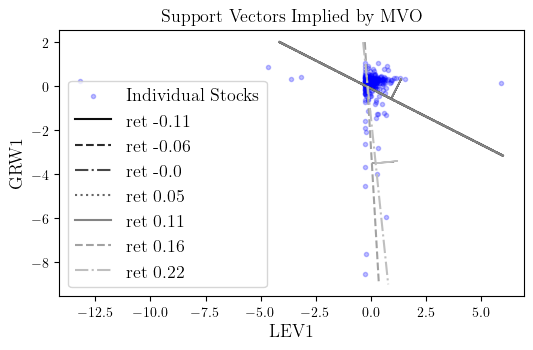

In [107]:
fig, ax = plt.subplots(figsize=(6,4))
supports_uniq  = supports.loc[supports.index%3 == 0]
ret_range = supports_uniq.ret.max() - supports_uniq.ret.min()

# Plot volatility versus expected return for individual stocks
ax.scatter(x=Y_normalized.iloc[:,0], y=Y_normalized.iloc[:,1],
           color='Blue', label='Individual Stocks', marker = '.', alpha = 0.25)
# for stock in Y_normalized.index:
#   ax.annotate(stock, (Y_normalized.loc[stock][0], Y_normalized.loc[stock[1]))

from itertools import cycle
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

for i in range(supports_uniq[[0,1,2]].values.shape[0]):
  print(i)
  line = getline(supports_uniq[[0,1,2]].values[i,:], xu, yu, xl, yl)
  if line is not None and line != []:
    line_col = str(0.7*(supports_uniq.ret.iloc[i] - supports_uniq.ret.min())/ret_range + 0.05)
    #ax.plot(*zip(*line), label = supports_uniq.iloc[i].desc, color = line_col, linestyle = next(linecycler))
    ax.plot(*zip(*line), label = "ret "+ str(np.round(supports_uniq.iloc[i].ret, decimals = 2)), color = line_col, linestyle = next(linecycler))
    print(line)
    mid = 0.5 * np.array(line[0]) + 0.5 * np.array(line[1])
    dir_ =  0.5*(np.array(line[0]) - np.array(line[1]))
    normal = supports_uniq[[0,1]].values[i,:]/(np.linalg.norm(supports_uniq[[0,1]].values[i,:]))
    conjugate_dir_ = [normal[0], normal[1]]
    print(conjugate_dir_)
    ax.arrow(mid[0], mid[1], conjugate_dir_[0], conjugate_dir_[1], color = line_col)

plt.legend(loc = 'lower left', fontsize = 16)
plt.ylabel(Y_normalized.columns[1], fontsize = 16)
plt.xlabel(Y_normalized.columns[0], fontsize = 16)
plt.title('Support Vectors Implied by MVO', fontsize = 16)
plt.gca().set_aspect('equal')
plt.savefig(pth+"Images/p3.svg")